In [91]:
# PART 0: Downloading the Data

import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt 
import scikit_posthocs as sp 

from scipy.stats import levene, kruskal

# I put the data in a folder named data/
# The data is too large to upload to github, so this is only local. 
path_0 = "data/exported_new_results_nih_funded_gene_annotations_clean-000000000000.csv"
path_1 = "data/exported_new_results_nih_funded_gene_annotations_clean-000000000001.csv"

raw_data_0 = pd.read_csv(path_0)
raw_data_1 = pd.read_csv(path_1)


In [92]:
# Just looking at the parts of the data
print(raw_data_0.columns)
print(raw_data_0.shape)
print(raw_data_1.columns)
print(raw_data_1.shape)

Index(['DB_Object_Symbol', 'DB_Object_Name', 'DB_Object_ID', 'DB_Object_Type',
       'DB_Object_Synonym', 'GO_ID', 'Aspect', 'Qualifier', 'Evidence_Code',
       'pmid_extracted', 'PMID', 'DB_Reference', 'PROJECT_NUMBER',
       'APPLICATION_ID', 'PROJECT_TITLE', 'PI_NAMEs', 'ORG_NAME', 'ORG_STATE',
       'ORG_COUNTRY', 'TOTAL_COST', 'DIRECT_COST_AMT', 'INDIRECT_COST_AMT',
       'FY', 'PROJECT_START', 'PROJECT_END', 'ACTIVITY', 'FULL_PROJECT_NUM',
       'PROJECT_TERMS', 'PHR', 'annotation_date', 'Assigned_By', 'Taxon'],
      dtype='object')
(197441, 32)
Index(['DB_Object_Symbol', 'DB_Object_Name', 'DB_Object_ID', 'DB_Object_Type',
       'DB_Object_Synonym', 'GO_ID', 'Aspect', 'Qualifier', 'Evidence_Code',
       'pmid_extracted', 'PMID', 'DB_Reference', 'PROJECT_NUMBER',
       'APPLICATION_ID', 'PROJECT_TITLE', 'PI_NAMEs', 'ORG_NAME', 'ORG_STATE',
       'ORG_COUNTRY', 'TOTAL_COST', 'DIRECT_COST_AMT', 'INDIRECT_COST_AMT',
       'FY', 'PROJECT_START', 'PROJECT_END', 'ACTIVITY', 

In [93]:
# PART 1: Pre-Processing the Data

# Concatenate the two datafiles together, check that it worked. 
data = pd.concat((raw_data_0, raw_data_1), ignore_index=True)
data.shape

(395002, 32)

In [94]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395002 entries, 0 to 395001
Data columns (total 32 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   DB_Object_Symbol   395002 non-null  object 
 1   DB_Object_Name     395002 non-null  object 
 2   DB_Object_ID       395002 non-null  object 
 3   DB_Object_Type     395002 non-null  object 
 4   DB_Object_Synonym  394840 non-null  object 
 5   GO_ID              395002 non-null  object 
 6   Aspect             395002 non-null  object 
 7   Qualifier          395002 non-null  object 
 8   Evidence_Code      395002 non-null  object 
 9   pmid_extracted     395002 non-null  int64  
 10  PMID               395002 non-null  int64  
 11  DB_Reference       395002 non-null  object 
 12  PROJECT_NUMBER     395002 non-null  object 
 13  APPLICATION_ID     395002 non-null  int64  
 14  PROJECT_TITLE      395002 non-null  object 
 15  PI_NAMEs           395002 non-null  object 
 16  OR

In [95]:
print(data['ORG_STATE'].unique())
print(data['ORG_COUNTRY'].unique())

['NE' 'MA' 'KS' 'HI' 'BC' 'OH' 'MD' 'WA' 'WI' 'NY' 'PA' 'TX' 'GA' 'SC'
 'NC' 'DC' 'NJ' 'FL' 'TN' 'MO' 'CA' 'IA' 'VT' 'CT' 'MN' 'IL' 'RI' 'AR'
 'VA' 'MI' 'OR' 'AZ' 'CO' 'AL' 'KY' 'OK' 'MT' 'ME' 'IN' 'ND' nan 'NV' 'LA'
 'NH' 'UT' 'MS' 'NM' 'WV' 'WY' 'ON' 'PQ' 'DE' 'QC' 'SD']
['UNITED STATES' 'CANADA' 'COLOMBIA' 'UNITED KINGDOM' 'BELGIUM' 'ISRAEL'
 'SPAIN' 'AUSTRALIA' 'CHINA' 'BRAZIL']


In [96]:
# confirming  that nan is state is associated with non-US countries (does not need to be handled) 
data[data['ORG_STATE'].isna()]["ORG_COUNTRY"].unique()

array(['COLOMBIA', 'UNITED KINGDOM', 'BELGIUM', 'ISRAEL', 'SPAIN',
       'AUSTRALIA', 'CHINA', 'BRAZIL'], dtype=object)

In [97]:
# checking for other null values (want to look specifically at model organisms (RQ1) and proteins(RQ2))
data[data['PMID'].isna()]
data[data['Taxon'].isna()] # organism group

data[data["PMID"].isna()] # gene symbol, uniprot id 
data[data["pmid_extracted"].isna()] # gene symbol, uniprot id 

,DB_Object_Symbol,DB_Object_Name,DB_Object_ID,DB_Object_Type,DB_Object_Synonym,GO_ID,Aspect,Qualifier,Evidence_Code,pmid_extracted,...,FY,PROJECT_START,PROJECT_END,ACTIVITY,FULL_PROJECT_NUM,PROJECT_TERMS,PHR,annotation_date,Assigned_By,Taxon


In [98]:
data['DB_Object_Type'].unique()

array(['protein'], dtype=object)

In [99]:
data.head()

,DB_Object_Symbol,DB_Object_Name,DB_Object_ID,DB_Object_Type,DB_Object_Synonym,GO_ID,Aspect,Qualifier,Evidence_Code,pmid_extracted,...,FY,PROJECT_START,PROJECT_END,ACTIVITY,FULL_PROJECT_NUM,PROJECT_TERMS,PHR,annotation_date,Assigned_By,Taxon
0,Pink1,"Serine/threonine-protein kinase PINK1, mitocho...",B5DFG1,protein,Pink1,GO:0031999,P,involved_in,HMP,25421206,...,2014,2005-02-10,2016-03-31,R01,5R01MH073490-11,Address;AIDS neuropathy;Autophagocytosis;Brain...,While treatment for HIV infection has improve...,20210212,RGD,taxon:10116
1,Pink1,"Serine/threonine-protein kinase PINK1, mitocho...",B5DFG1,protein,Pink1,GO:0000266,P,involved_in,HMP,25421206,...,2014,2005-02-10,2016-03-31,R01,5R01MH073490-11,Address;AIDS neuropathy;Autophagocytosis;Brain...,While treatment for HIV infection has improve...,20210212,RGD,taxon:10116
2,Nf1,"Neurofibromin 1, isoform B",Q9VBJ2,protein,Nf1|Dmel\CG8318|FBpp0084326|NF-1|NF1|Nf-1|dNF1...,GO:0008344,P,involved_in,IMP,25962619,...,2016,2008-09-01,2020-07-31,R01,2R01GM084947-09,Address;base;Cells;Clustered Regularly Intersp...,PROJECT NARRATIVE This project is seeking cont...,20160811,FlyBase,taxon:7227
3,Cirl,Latrophilin Cirl,A1Z7G7,protein,Cirl|CG8639,GO:0008344,P,involved_in,IMP,25962619,...,2013,2008-09-01,2016-07-31,R01,5R01GM084947-06,NaN,This project is seeking continued support...,20160811,FlyBase,taxon:7227
4,DAT,Sodium-dependent dopamine transporter,Q7K4Y6,protein,DAT|fmn|CG8380,GO:0008344,P,involved_in,IMP,25962619,...,2014,2008-09-01,2016-07-31,R01,5R01GM084947-07,Address;base;Biological;Biological Assay;Biolo...,This project is seeking continued support...,20160811,FlyBase,taxon:7227


In [100]:
print(len(data['PROJECT_NUMBER']), len(data['PROJECT_NUMBER'].unique()))

395002 4970


In [101]:
# for each project taxon, divide money by number of taxons that project has (avoids double counting and 
# maintains assumption of independence)
data['num_taxons'] = data.groupby('PROJECT_NUMBER')['Taxon'].transform('count')
data['TOTAL_COST'] = data['TOTAL_COST']/data['num_taxons'] 

<Axes: >

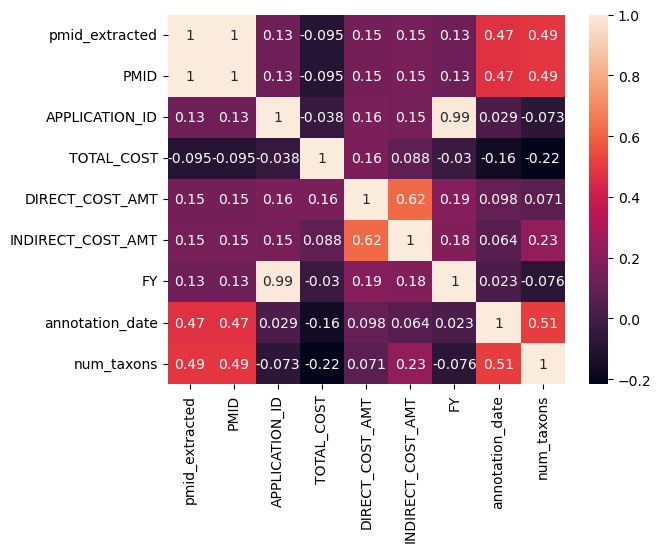

In [102]:
# -- PART 2: High Level Overview 

# correlation map on quantitative variables (general)
corr_matrix = data.select_dtypes(include=[np.number]).corr()
plt.figure()
sns.heatmap(corr_matrix, annot=True)

In [103]:
# correlation map on categorical variables 

In [104]:
# -- PART 3: General Functions 
def add_rank_cols(df, cost_col):
    df['total_cost_rank'] = df[cost_col].rank(method = 'min', ascending=False).astype(int)
    return df 

# given data from 2013 to 2022, rank column to see how the taxon ranks over time  
def add_rank_by_year(df, year, new_col_name):
    df[new_col_name] = df[year].rank(method = 'min', ascending=False).astype('Int64')
    return df 

# get top x data points for a specific column in a df (asc = if True, return in ascending order, o/w descending)
def get_top_x(df, col, num, asc): 
    mod_df = df.sort_values(col, ascending = True).head(num).reset_index()
    mod_df = mod_df.sort_values(col, ascending = asc)

    return mod_df 

# given the aggregated data column (prior to taking only top) and then the top 10, 
# create a column Other that has the cost_col of all the non-top 10 
def format_for_pie(agg_df, top_df, cost_col, var_col): 
    count = top_df[cost_col].to_list()
    labels = top_df[var_col].to_list()

    # get other column, then add to count and labels list 
    other = agg_df[cost_col].sum() - top_df[cost_col].sum()
    count.append(other)
    labels.append('Other')

    return count, labels 


In [105]:
# -- PART 4: RQ1 - How much NIH money is spent on different model organisms? Is there a bias?

# x = model organism = Taxon, y = TOTAL_COST

# Task 1: Evaluate overall NIH money across all time (do year after)

# group data by total cost per taxon across all time 
df_cost_taxon = data[['Taxon', 'TOTAL_COST']]
tot_cost_per_taxon = df_cost_taxon.groupby('Taxon').agg(
    #num_projects = ('Taxon', 'size'), 
    total_cost = ('TOTAL_COST', 'sum')
    ).sort_values(by = 'total_cost', ascending=False)

# add ranking columns for how they rank against other taxons 
tot_cost_per_taxon = add_rank_cols(tot_cost_per_taxon, 'total_cost')

tot_cost_per_taxon.head()

,total_cost,total_cost_rank
Taxon,,
taxon:9606,6.377140e+08,1
taxon:10090,5.658119e+08,2
taxon:7955,1.871745e+08,3
taxon:7227,1.271345e+08,4
taxon:10116,9.033587e+07,5


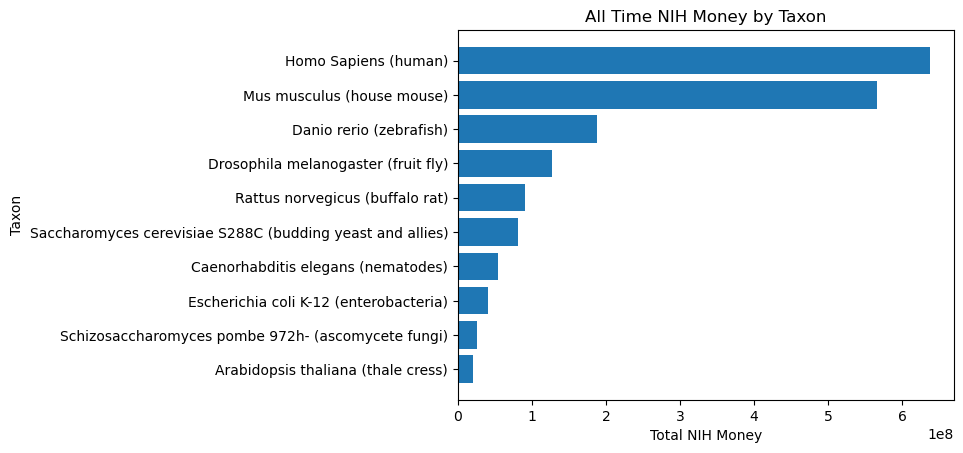

In [106]:
# get top 10 taxons with the highest total cost 
t10_taxon_cost = get_top_x(tot_cost_per_taxon, 'total_cost_rank', 10, False)

# map to human terminology 
mapping = {
    'taxon:9606':'Homo Sapiens (human)',
    'taxon:10090':'Mus musculus (house mouse)',
    'taxon:7227':'Drosophila melanogaster (fruit fly)',
    'taxon:559292':'Saccharomyces cerevisiae S288C (budding yeast and allies)',
    'taxon:7955':'Danio rerio (zebrafish)',
    'taxon:6239':'Caenorhabditis elegans (nematodes)',
    'taxon:185431':'Trypanosoma brucei brucei TREU927 (kinetoplastids)',
    'taxon:10116':'Rattus norvegicus (buffalo rat)',
    'taxon:284812':'Schizosaccharomyces pombe 972h- (ascomycete fungi)',
    'taxon:83333':'Escherichia coli K-12 (enterobacteria)',
    'taxon:3702':'Arabidopsis thaliana (thale cress)'
}

t10_taxon_cost['Taxon'] = t10_taxon_cost['Taxon'].replace(mapping)

# visualize as a bar plot 
plt.barh(t10_taxon_cost['Taxon'], t10_taxon_cost['total_cost'])
plt.xlabel('Total NIH Money')
plt.ylabel('Taxon')
plt.title('All Time NIH Money by Taxon')
plt.show()

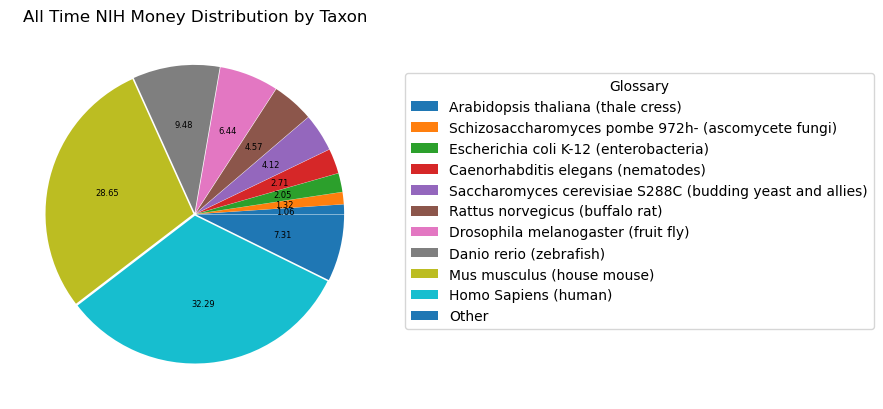

In [107]:
# visualize as a pie chart, comparing against ALL others 
t10_taxon_pie = format_for_pie(tot_cost_per_taxon, t10_taxon_cost, 'total_cost', 'Taxon')
plt_explode = [0.01]*11 #[0,0,0,0,0,0,0,0,0,0,0]
#plt.pie(t10_taxon_pie[0], explode = plt_explode)
plt.pie(t10_taxon_pie[0], autopct='%.2f', textprops = {'fontsize':6}, explode = plt_explode)
plt.legend(t10_taxon_pie[1], title = 'Glossary', bbox_to_anchor = (1.05, 0.9))
plt.title('All Time NIH Money Distribution by Taxon')
plt.show()

In [108]:
# Task 2: Now that we know the overall max, we want to see if these rankings are consistent over time 

# create dataframes that look at the total cost and the number of projects over time
df_rank_time = data[['Taxon', 'TOTAL_COST', 'FY']]

taxon_rank_cost_by_year = df_rank_time.groupby(['Taxon', 'FY']).agg(
#    num_projects = ('Taxon', 'size'), 
    total_cost = ('TOTAL_COST', 'sum')
).reset_index().pivot(index='Taxon', columns = 'FY', values = 'total_cost')

# add ranking columns for how they rank against other taxons (cost)
taxon_rank_cost_by_year = add_rank_by_year(taxon_rank_cost_by_year, 2016, '2016_rank')
taxon_rank_cost_by_year = add_rank_by_year(taxon_rank_cost_by_year, 2017, '2017_rank')
taxon_rank_cost_by_year = add_rank_by_year(taxon_rank_cost_by_year, 2018, '2018_rank')
taxon_rank_cost_by_year = add_rank_by_year(taxon_rank_cost_by_year, 2019, '2019_rank')
taxon_rank_cost_by_year = add_rank_by_year(taxon_rank_cost_by_year, 2020, '2020_rank')
taxon_rank_cost_by_year = add_rank_by_year(taxon_rank_cost_by_year, 2021, '2021_rank')
taxon_rank_cost_by_year = add_rank_by_year(taxon_rank_cost_by_year, 2022, '2022_rank')

taxon_rank_cost_by_year.head(20)

FY,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2016_rank,2017_rank,2018_rank,2019_rank,2020_rank,2021_rank,2022_rank
Taxon,,,,,,,,,,,,,,,,,
taxon:10036,8.613333e+03,8.866667e+03,8.911905e+03,9.047619e+03,NaN,NaN,NaN,NaN,NaN,NaN,120,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
taxon:10090,6.848804e+07,6.756321e+07,7.115934e+07,7.227789e+07,6.836378e+07,6.306487e+07,5.262364e+07,4.293762e+07,3.322792e+07,2.610560e+07,2,2,2,2,2,2,2
taxon:10090|taxon:64320,NaN,NaN,NaN,NaN,NaN,1.065511e+04,1.036526e+04,1.049996e+04,1.002054e+04,1.823794e+04,<NA>,<NA>,106,96,84,69,55
taxon:10116,1.618577e+07,1.372187e+07,1.142331e+07,1.075375e+07,9.663762e+06,8.542293e+06,6.543712e+06,5.365700e+06,4.531283e+06,3.604413e+06,5,5,6,6,6,6,6
taxon:10254,1.793647e+05,1.914283e+05,2.096649e+05,1.736530e+05,3.378000e+05,2.868497e+05,2.880979e+05,3.268974e+05,2.756682e+05,9.473976e+04,29,22,22,23,20,20,30
taxon:10299,2.639258e+05,4.123081e+05,4.023123e+05,3.693166e+05,3.843456e+05,2.804657e+05,2.018160e+05,2.994687e+05,1.897002e+05,9.896712e+04,18,20,23,28,22,25,28
taxon:10315,8.152444e+03,7.907867e+03,8.152444e+03,8.152444e+03,8.152444e+03,NaN,9.478889e+03,9.478889e+03,9.478889e+03,9.289311e+03,122,117,<NA>,98,86,72,61
taxon:10377,3.485196e+04,3.588648e+04,3.690744e+04,3.680928e+04,3.720000e+03,NaN,NaN,NaN,NaN,NaN,88,123,<NA>,<NA>,<NA>,<NA>,<NA>
taxon:10665,7.795657e+04,8.187186e+04,9.322500e+04,9.126071e+04,9.126071e+04,9.126071e+04,9.126071e+04,NaN,NaN,NaN,51,50,49,47,<NA>,<NA>,<NA>


In [109]:
# look at the top 5 taxons and drop all columns unrelated to rank
t5_taxon = ['taxon:9606', 'taxon:10090', 'taxon:7955', 'taxon:7227', 'taxon:10116']
t5_taxon_rank_cost_by_year = taxon_rank_cost_by_year[
    taxon_rank_cost_by_year.index.isin(t5_taxon)
].sort_values('2016_rank', ascending=True).reset_index()[
    ['Taxon', '2016_rank', '2017_rank', '2018_rank', '2019_rank', '2020_rank', '2021_rank', '2022_rank']
]

# map to human terminology 
taxon_mapping = {
    'taxon:9606':'Homo Sapiens (human)',
    'taxon:10090':'Mus musculus (house mouse)',
    'taxon:7227':'Drosophila melanogaster (fruit fly)',
    'taxon:559292':'Saccharomyces cerevisiae S288C (budding yeast and allies)',
    'taxon:7955':'Danio rerio (zebrafish)',
    'taxon:6239':'Caenorhabditis elegans (nematodes)',
    'taxon:185431':'Trypanosoma brucei brucei TREU927 (kinetoplastids)',
    'taxon:10116':'Rattus norvegicus (buffalo rat)',
    'taxon:284812':'Schizosaccharomyces pombe 972h- (ascomycete fungi)',
    'taxon:83333':'Escherichia coli K-12 (enterobacteria)',
    'taxon:3702':'Arabidopsis thaliana (thale cress)'
}

t5_taxon_rank_cost_by_year['Taxon'] = t5_taxon_rank_cost_by_year['Taxon'].replace(taxon_mapping)
t5_taxon_rank_cost_by_year

FY,Taxon,2016_rank,2017_rank,2018_rank,2019_rank,2020_rank,2021_rank,2022_rank
0,Homo Sapiens (human),1,1,1,1,1,1,1
1,Mus musculus (house mouse),2,2,2,2,2,2,2
2,Danio rerio (zebrafish),3,3,3,3,3,3,3
3,Drosophila melanogaster (fruit fly),4,4,4,4,4,4,4
4,Rattus norvegicus (buffalo rat),5,5,6,6,6,6,6


In [110]:
# Task 3: Given that human is clearly the most heavily funded and has the most 
# number of projects, lets take a look at how funding and number of projects has 
# varied over time 

# 1 = taxon:9606 (human), 2 = taxon:10090 (house mouse), 3 = taxon:7227 (fruit fly), 
# 4 = taxon:559292 (brewer's yeast), 5 = taxon:7955 (zebrafish)
#df_rank_time = data[['Taxon', 'TOTAL_COST', 'FY']]

# filter for only human taxons 
taxon_human = data[data['Taxon'] == 'taxon:9606'][['TOTAL_COST', 'FY']]

# get total cost and number of projects per year 
taxon_human_cost = taxon_human.groupby('FY').agg(
    total_cost = ('FY', 'sum')
).reset_index()

taxon_human_cost.head()

,FY,total_cost
0,2013,39400449
1,2014,52881598
2,2015,59517055
3,2016,59399424
4,2017,52008345


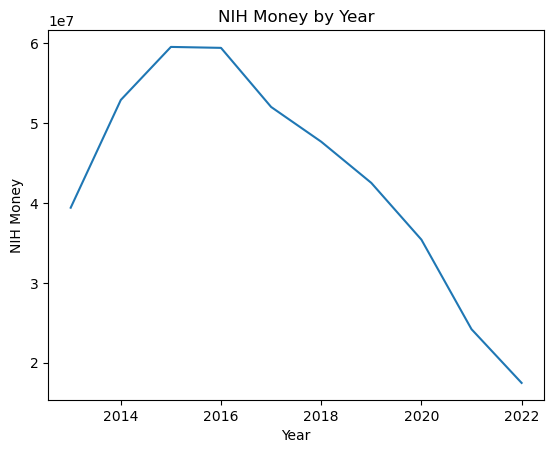

In [111]:
# plot a line graph showing how total cost and num projects have varied over time
plt.plot(taxon_human_cost['FY'], taxon_human_cost['total_cost'], label = 'Total NIH Funding of Projects')
plt.xlabel('Year')
plt.ylabel('NIH Money')
plt.title('NIH Money by Year')
plt.show()

In [112]:
# Task 4: Run a statistical test to see if there is any bias in the NIH funding for different 
# model organisms (spoiler alert: answer is yes)

# Kruskal-Wallis: checks for stat. significant differences between them 
# assumptions: ordinal (yes), independent samples (yes), 
# distributions of the groups must have the same shape (uncertain)

rq1_stat_df = data[['Taxon', 'TOTAL_COST']]

# create boxplot to check same shape 
#boxplot = sns.FacetGrid(rq1_stat_df, col = 'Taxon', col_wrap = 5, sharey = False)
#boxplot.map(sns.boxplot, 'TOTAL_COST')

In [154]:
# boxplot is difficult to visualize so switching to checking if distribution has similar 
# variance via Levene (conclusion: statistically significant, assumption is violated)
list_of_taxons = rq1_stat_df['Taxon'].unique()

data_by_taxon = []
kept_taxons = []
for taxon in list_of_taxons: 
    data_points = rq1_stat_df[rq1_stat_df['Taxon'] == taxon]['TOTAL_COST'].values

    # avoids nan issue with fewer than 5 data points
    if len(data_points) > 50 and np.std(data_points) > 0: 
        data_by_taxon.append(data_points)
        kept_taxons.append(taxon)

f, p = levene(*data_by_taxon)
print(f, p)
#len(kept_taxons)

175.36286035959716 0.0


In [155]:
# Run Kruskal-Wallis test (high significance value, indicating a bias)
H, p = kruskal(*data_by_taxon)
print(H, p)

93402.62135679061 0.0


Text(0.5, 1.0, 'Heat Map of Dunn Test Results (p-values)')

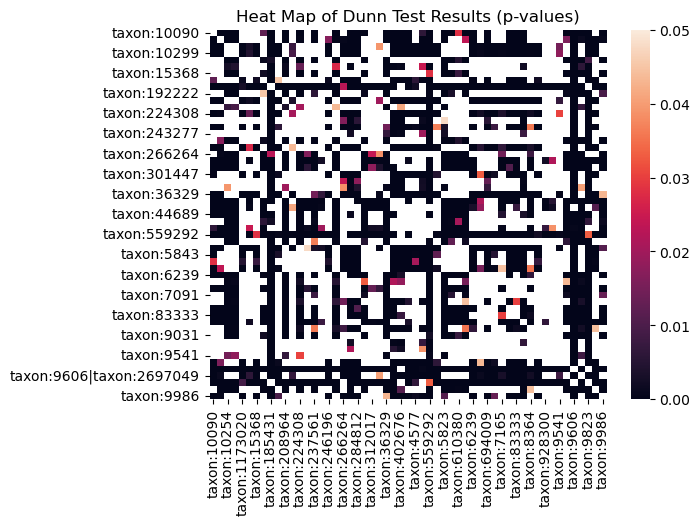

In [157]:
# Run Dunn Test (post-hoc)

# remove N/A values from df
dunn_df = rq1_stat_df[rq1_stat_df['Taxon'].isin(kept_taxons)][['Taxon', 'TOTAL_COST']]
p_values = sp.posthoc_dunn(
    dunn_df, 
    group_col = 'Taxon',
    val_col = 'TOTAL_COST', 
    p_adjust='holm'
)


# use correlation matrix to visualize statistical significance (only looking at p<0.5)
plt.figure()
sns.heatmap(
    p_values.where(p_values <= 0.05),
    vmin = 0, 
    vmax = 0.05
)
plt.title("Heat Map of Dunn Test Results (p-values)")

# values are filtered for statistical significance, can see several extremely dark values
# specifically black, indicating high presence of bias in NIH funding based on taxon 

In [116]:
# -- PART 5: RQ2 - How much NIH money is spent on different proteins? Is there a bias?

# protein = DB_Object_ID  

In [117]:
# -- PART 6: RQ3 - How much NIH money is spent on different functions? Is there a bias?

# x = function = GO_ID, y = TOTAL_COST 

# Task 1: Evaluate overall NIH money across all time (do year after)

# group data by total cost per function across all time 
df_cost_function = data[['GO_ID', 'TOTAL_COST']]
tot_cost_per_function = df_cost_function.groupby('GO_ID').agg(
    #num_projects = ('Taxon', 'size'), 
    total_cost = ('TOTAL_COST', 'sum')
    ).sort_values(by = 'total_cost', ascending=False)

# add ranking columns for how they rank against other taxons 
tot_cost_per_function = add_rank_cols(tot_cost_per_function, 'total_cost')

tot_cost_per_function.head()

,total_cost,total_cost_rank
GO_ID,,
GO:0005515,2.178586e+08,1
GO:0005634,2.938860e+07,2
GO:0005886,2.574398e+07,3
GO:0042802,2.032213e+07,4
GO:0005737,1.589172e+07,5


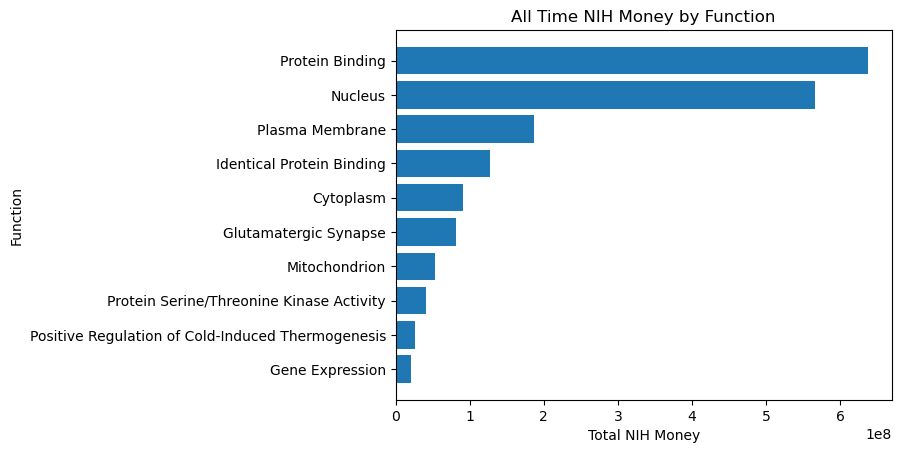

In [118]:
t10_function_cost = get_top_x(tot_cost_per_function, 'total_cost_rank', 10, False)

# map to human terminology 
function_mapping = {
    'GO:0005515':'Protein Binding',
    'GO:0005634':'Nucleus',
    'GO:0005886':'Plasma Membrane',
    'GO:0042802':'Identical Protein Binding',
    'GO:0005737':'Cytoplasm',
    'GO:0098978':'Glutamatergic Synapse',
    'GO:0005739':'Mitochondrion',
    'GO:0004674':'Protein Serine/Threonine Kinase Activity',
    'GO:0120162':'Positive Regulation of Cold-Induced Thermogenesis',
    'GO:0010467':'Gene Expression'
}

t10_function_cost['GO_ID'] = t10_function_cost['GO_ID'].replace(function_mapping)

# visualize as a bar plot 
plt.barh(t10_function_cost['GO_ID'], t10_taxon_cost['total_cost'])
plt.xlabel('Total NIH Money')
plt.ylabel('Function')
plt.title('All Time NIH Money by Function')
plt.show()


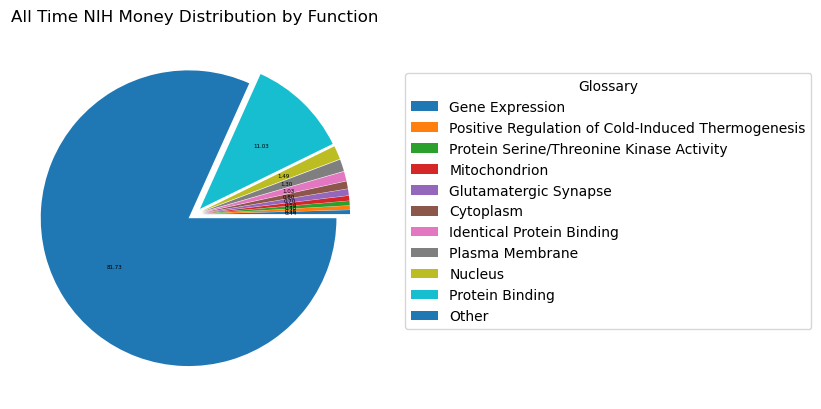

In [119]:
# visualize as a pie chart, comparing against ALL others 
t10_function_pie = format_for_pie(tot_cost_per_function, t10_function_cost, 'total_cost', 'GO_ID')
plt_explode = [0.05]*11 #[0,0,0,0,0,0,0,0,0,0,0]
#plt.pie(t10_function_pie[0], explode = plt_explode)
plt.pie(t10_function_pie[0], autopct='%.2f', textprops = {'fontsize':4}, explode = plt_explode)
plt.legend(t10_function_pie[1], title = 'Glossary', bbox_to_anchor = (1.05, 0.9))
plt.title('All Time NIH Money Distribution by Function')
plt.show()

In [120]:
# Task 2: Now that we know the overall max, we want to see if these rankings are consistent over time 

# create dataframes that look at the total cost and the number of projects over time
df_func_rank_time = data[['GO_ID', 'TOTAL_COST', 'FY']]

function_rank_cost_by_year = df_func_rank_time.groupby(['GO_ID', 'FY']).agg(
    total_cost = ('TOTAL_COST', 'sum')
).reset_index().pivot(index='GO_ID', columns = 'FY', values = 'total_cost')

# add ranking columns for how they rank against other taxons (cost)
function_rank_cost_by_year = add_rank_by_year(function_rank_cost_by_year, 2016, '2016_rank')
function_rank_cost_by_year = add_rank_by_year(function_rank_cost_by_year, 2017, '2017_rank')
function_rank_cost_by_year = add_rank_by_year(function_rank_cost_by_year, 2018, '2018_rank')
function_rank_cost_by_year = add_rank_by_year(function_rank_cost_by_year, 2019, '2019_rank')
function_rank_cost_by_year = add_rank_by_year(function_rank_cost_by_year, 2020, '2020_rank')
function_rank_cost_by_year = add_rank_by_year(function_rank_cost_by_year, 2021, '2021_rank')
function_rank_cost_by_year = add_rank_by_year(function_rank_cost_by_year, 2022, '2022_rank')

function_rank_cost_by_year.head(20)

FY,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2016_rank,2017_rank,2018_rank,2019_rank,2020_rank,2021_rank,2022_rank
GO_ID,,,,,,,,,,,,,,,,,
GO:0000006,6840.250000,9647.670000,9882.810000,9867.840000,2856.300000,2852.120000,NaN,NaN,NaN,NaN,3187,4071,3869,<NA>,<NA>,<NA>,<NA>
GO:0000012,12760.433333,12632.833333,12760.433333,12760.433333,12760.433333,13088.533333,13088.533333,13088.533333,13088.533333,13088.533333,2865,2750,2563,2236,1905,1560,1288
GO:0000018,9773.863636,10085.809091,10397.727273,10397.727273,10128.409091,10192.036364,32238.081818,32544.327273,32544.327273,32684.536364,3119,3056,2878,1268,1037,822,622
GO:0000027,79329.875000,14759.375000,22127.325000,22107.575000,22087.158333,7387.200000,NaN,NaN,NaN,NaN,2126,2020,3174,<NA>,<NA>,<NA>,<NA>
GO:0000028,NaN,NaN,105131.282895,97514.592105,96968.190789,253222.032895,122388.750000,122388.750000,NaN,NaN,525,504,96,271,209,<NA>,<NA>
GO:0000030,8256.125000,8244.321429,8232.196429,8219.714286,19285.750000,18660.750000,18660.750000,18660.750000,NaN,NaN,3403,2189,2095,1848,1564,<NA>,<NA>
GO:0000035,NaN,5413.545455,5287.363636,6395.348485,5514.939394,5544.196970,7814.484848,7827.106061,7827.106061,7827.106061,3649,3635,3431,2769,2382,1974,1673
GO:0000045,1954.638889,33141.777778,36527.859596,36825.950505,37579.873232,98087.332828,82598.746465,79297.830556,79493.997222,2763.761111,1436,1371,464,483,403,297,2309
GO:0000049,17739.216518,18317.820685,18382.570685,13845.251667,39129.413704,38686.358148,38699.321111,38779.515556,31017.074074,33484.518519,2778,1317,1230,1082,881,865,613


In [121]:
# look at the top 5 taxons and drop all columns unrelated to rank
t5_function = ['GO:0005515', 'GO:0005634', 'GO:0005886', 'GO:0042802', 'GO:0005737']
t5_function_rank_cost_by_year = function_rank_cost_by_year[
    function_rank_cost_by_year.index.isin(t5_function)
].sort_values('2016_rank', ascending=True).reset_index()[
    ['GO_ID', '2016_rank', '2017_rank', '2018_rank', '2019_rank', '2020_rank', '2021_rank', '2022_rank']
]

# can see that while protein binding has consistently remained 1, nucleus funding has dropped starting in 
# 2019, to be replaced by identical protein binding 
t5_function_rank_cost_by_year['GO_ID'] = t5_function_rank_cost_by_year['GO_ID'].replace(mapping)
t5_function_rank_cost_by_year

FY,GO_ID,2016_rank,2017_rank,2018_rank,2019_rank,2020_rank,2021_rank,2022_rank
0,GO:0005515,1,1,1,1,1,1,1
1,GO:0005634,2,2,2,2,3,3,3
2,GO:0005886,3,3,3,4,4,4,4
3,GO:0005737,4,5,5,5,5,13,7
4,GO:0042802,5,4,4,3,2,2,2


In [122]:
# Task 3: Given that protein binding is clearly the most heavily funded and has the most 
# lets take a look at how funding and number of projects has varied over time

# 1 = taxon:9606 (human), 2 = taxon:10090 (house mouse), 3 = taxon:7227 (fruit fly), 
# 4 = taxon:559292 (brewer's yeast), 5 = taxon:7955 (zebrafish)
#df_rank_time = data[['Taxon', 'TOTAL_COST', 'FY']]

# filter for only human taxons 
function_prot_binding = data[data['GO_ID'] == 'GO:0005515'][['TOTAL_COST', 'FY']]

# get total cost and number of projects per year 
function_prot_binding_cost = function_prot_binding.groupby('FY').agg(
    total_cost = ('FY', 'sum')
).reset_index()

function_prot_binding_cost.head()

,FY,total_cost
0,2013,25699971
1,2014,37025376
2,2015,41277275
3,2016,40509504
4,2017,34397918


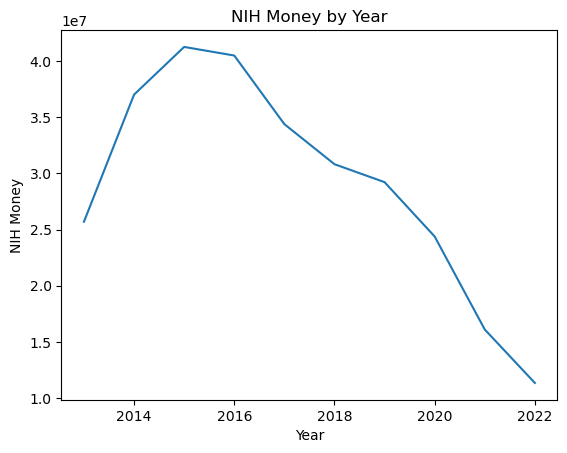

In [123]:
# plot a line graph showing how total cost has varied over time
plt.plot(function_prot_binding_cost['FY'], function_prot_binding_cost['total_cost'], label = 'Total NIH Funding of Projects')
plt.xlabel('Year')
plt.ylabel('NIH Money')
plt.title('NIH Money by Year')
plt.show()

In [131]:
# Task 4: Run a statistical test to see if there is any bias in the NIH funding for different 
# model functions (appears to be for protein binding, but other than that, not so much)

# Kruskal-Wallis: checks for stat. significant differences between them 
# assumptions: ordinal (yes), independent samples (yes), 
# distributions of the groups must have the same shape (uncertain)

rq3_stat_df = data[['GO_ID', 'TOTAL_COST']]

# Levene test (conclusion: statistically significant, assumption is violated)
list_of_functions = rq3_stat_df['GO_ID'].unique()

data_by_function = []
kept_functions = []
for function in list_of_functions: 
    data_points = rq3_stat_df[rq3_stat_df['GO_ID'] == function]['TOTAL_COST'].values

    # making 200 so we have 20-40 groups 
    if len(data_points) > 400 and np.std(data_points) > 0: 
        data_by_function.append(data_points)
        kept_functions.append(function)

f, p = levene(*data_by_function)
print(f, p)

171.47802260601605 0.0


In [132]:
# Run Kruskal-Wallis test (high significance value, indicating a bias)
H, p = kruskal(*data_by_function)
print(H, p)

61593.95700242142 0.0


Text(0.5, 1.0, 'Heat Map of Dunn Test Results (p-values)')

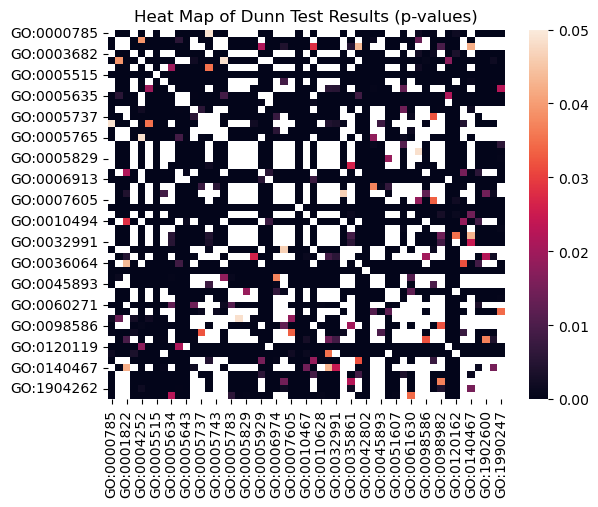

In [ ]:
# Run Dunn Test (post-hoc)

# remove N/A values from df
dunn_df = rq3_stat_df[rq3_stat_df['GO_ID'].isin(kept_functions)][['GO_ID', 'TOTAL_COST']]
p_values = sp.posthoc_dunn(
    dunn_df, 
    group_col = 'GO_ID',
    val_col = 'TOTAL_COST', 
    p_adjust='holm'
)

# use correlation matrix to visualize statistical significance (only looking at p<0.5)
plt.figure()
sns.heatmap(
    p_values.where(p_values <= 0.05),
    vmin = 0, 
    vmax = 0.05
)
plt.title("Heat Map of Dunn Test Results (p-values)")

# values are filtered for statistical significance, can see several extremely dark values
# specifically black, indicating high presence of bias in NIH funding based on function 

In [ ]:
# -- PART 7: How much NIH money is awarded to different institutions? Is there a bias?

# institution = ORG_NAME

In [135]:
# -- PART 8: How much NIH money is awarded to different states? Is there a bias?

# x = state = ORG_STATE, y = TOTAL_COST 

# Task 1: Evaluate overall NIH money across all time (do year after)

# group data by total cost per taxon across all time 
df_cost_state = data[['ORG_STATE', 'TOTAL_COST']]
tot_cost_per_state = df_cost_state.groupby('ORG_STATE').agg(
    total_cost = ('TOTAL_COST', 'sum')
    ).sort_values(by = 'total_cost', ascending=False)

# add ranking columns for how they rank against other taxons 
tot_cost_per_state = add_rank_cols(tot_cost_per_state, 'total_cost')

tot_cost_per_state.head()

,total_cost,total_cost_rank
ORG_STATE,,
CA,3.276149e+08,1
MA,2.512201e+08,2
NY,2.124668e+08,3
PA,1.316181e+08,4
TX,1.289822e+08,5


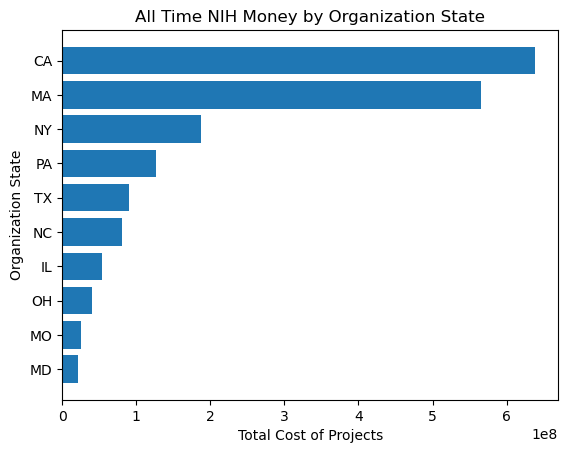

In [136]:
# get top 10 states with the highest total cost 
t10_state_cost = get_top_x(tot_cost_per_state, 'total_cost_rank', 10, False)

# visualize as a bar plot 
plt.barh(t10_state_cost['ORG_STATE'], t10_taxon_cost['total_cost'])
plt.xlabel('Total Cost of Projects')
plt.ylabel('Organization State')
plt.title('All Time NIH Money by Organization State')
plt.show()

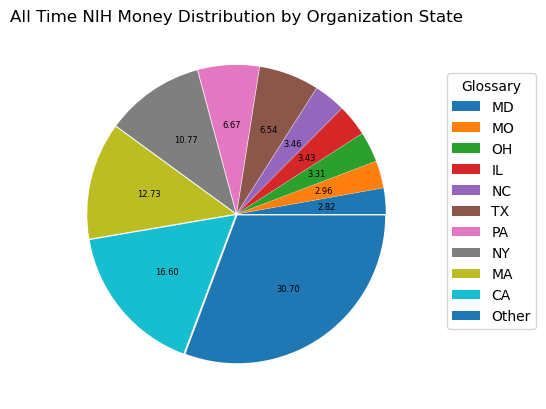

In [137]:
# visualize as a pie chart, comparing against ALL others 
t10_state_pie = format_for_pie(tot_cost_per_state, t10_state_cost, 'total_cost', 'ORG_STATE')
plt_explode = [0.01]*11 #[0,0,0,0,0,0,0,0,0,0,0]
#plt.pie(t10_state_pie[0], explode = plt_explode)
plt.pie(t10_state_pie[0], autopct='%.2f', textprops = {'fontsize':6}, explode = plt_explode)
plt.legend(t10_state_pie[1], title = 'Glossary', bbox_to_anchor = (1.05, 0.9))
plt.title('All Time NIH Money Distribution by Organization State')
plt.show()

In [138]:
# Task 2: Now that we know the overall max, we want to see if these rankings are consistent over time 

# create dataframes that look at the total cost and the number of projects over time
df_state_rank_time = data[['ORG_STATE', 'TOTAL_COST', 'FY']]

state_rank_cost_by_year = df_state_rank_time.groupby(['ORG_STATE', 'FY']).agg(
    total_cost = ('TOTAL_COST', 'sum')
).reset_index().pivot(index='ORG_STATE', columns = 'FY', values = 'total_cost')

# add ranking columns for how they rank against other taxons (cost)
state_rank_cost_by_year = add_rank_by_year(state_rank_cost_by_year, 2016, '2016_rank')
state_rank_cost_by_year = add_rank_by_year(state_rank_cost_by_year, 2017, '2017_rank')
state_rank_cost_by_year = add_rank_by_year(state_rank_cost_by_year, 2018, '2018_rank')
state_rank_cost_by_year = add_rank_by_year(state_rank_cost_by_year, 2019, '2019_rank')
state_rank_cost_by_year = add_rank_by_year(state_rank_cost_by_year, 2020, '2020_rank')
state_rank_cost_by_year = add_rank_by_year(state_rank_cost_by_year, 2021, '2021_rank')
state_rank_cost_by_year = add_rank_by_year(state_rank_cost_by_year, 2022, '2022_rank')

state_rank_cost_by_year.head(20)

FY,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2016_rank,2017_rank,2018_rank,2019_rank,2020_rank,2021_rank,2022_rank
ORG_STATE,,,,,,,,,,,,,,,,,
AL,1.591129e+06,8.979950e+05,1.154171e+06,1.382429e+06,1.817957e+06,1.503037e+06,1.268052e+06,9.458771e+05,6.871890e+05,3.955011e+05,26,25,25,26,26,27,30
AR,4.319215e+05,5.378296e+05,5.090484e+05,5.163487e+05,2.335194e+05,2.213801e+05,1.521965e+05,9.201077e+04,9.890890e+04,6.134533e+04,34,42,41,41,45,42,46
AZ,1.243580e+06,1.351433e+06,1.438149e+06,1.184386e+06,1.138404e+06,1.133570e+06,1.020741e+06,8.433522e+05,7.199147e+05,8.458875e+05,27,27,27,27,27,25,22
BC,1.340342e+05,1.360931e+05,1.358772e+05,5.359220e+04,5.359220e+04,NaN,NaN,NaN,NaN,NaN,51,48,<NA>,<NA>,<NA>,<NA>,<NA>
CA,4.513980e+07,4.150057e+07,4.200583e+07,4.099807e+07,3.730851e+07,3.480337e+07,2.870599e+07,2.297005e+07,1.861589e+07,1.556687e+07,1,1,1,1,1,1,1
CO,3.168383e+06,3.219040e+06,4.129661e+06,4.609607e+06,4.000841e+06,3.096964e+06,2.366732e+06,1.319580e+06,1.158202e+06,7.217262e+05,18,18,18,18,25,21,25
CT,6.397889e+06,6.806388e+06,7.314088e+06,7.924051e+06,7.246841e+06,6.133519e+06,4.371517e+06,3.335116e+06,2.417658e+06,2.245362e+06,7,8,10,13,13,13,11
DC,1.104556e+06,8.844675e+05,6.849113e+05,3.433616e+05,6.950020e+05,7.430300e+05,6.120396e+05,5.577404e+05,3.794462e+05,2.405634e+05,38,33,31,32,32,32,33
DE,6.096125e+04,6.317225e+04,6.317225e+04,1.065056e+05,4.333333e+04,4.333333e+04,1.292418e+05,1.662018e+05,1.647181e+05,1.633938e+05,47,50,49,43,40,39,38


In [139]:
# look at the top 5 states and drop all columns unrelated to rank
t5_state = ['CA', 'MA', 'NY', 'PA', 'TX']

t5_state_rank_cost_by_year = state_rank_cost_by_year[
    state_rank_cost_by_year.index.isin(t5_state)
].sort_values('2016_rank', ascending=True).reset_index()[
    ['ORG_STATE', '2016_rank', '2017_rank', '2018_rank', '2019_rank', '2020_rank', '2021_rank', '2022_rank']
]

t5_state_rank_cost_by_year

FY,ORG_STATE,2016_rank,2017_rank,2018_rank,2019_rank,2020_rank,2021_rank,2022_rank
0,CA,1,1,1,1,1,1,1
1,MA,2,2,2,2,2,2,2
2,NY,3,3,3,3,3,3,3
3,PA,4,4,4,5,5,5,5
4,TX,5,5,5,4,4,4,4


In [140]:
# Task 3: Given that California is clearly the most heavily funded 
# lets take a look at how funding and number of projects has varied over time

# filter for only human taxons 
state_ca = data[data['ORG_STATE'] == 'CA'][['TOTAL_COST', 'FY']]

# get total cost and number of projects per year 
state_ca_cost = state_ca.groupby('FY').agg(
    num_projects = ('FY', 'size'), 
    total_cost = ('FY', 'sum')
).reset_index()

state_ca_cost.head()

,FY,num_projects,total_cost
0,2013,5648,11369424
1,2014,6314,12716396
2,2015,6989,14082835
3,2016,7793,15710688
4,2017,6781,13677277


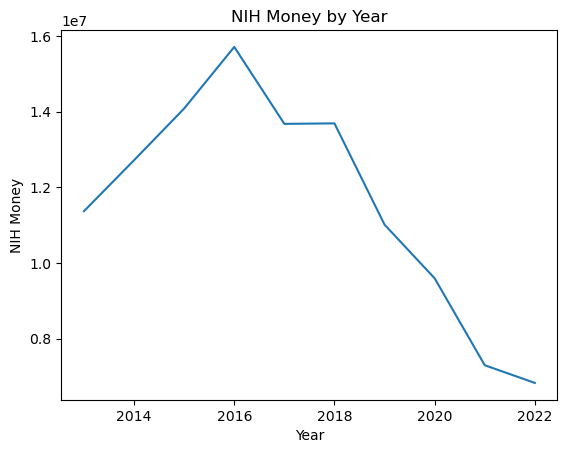

In [141]:
# plot a line graph showing how total cost and num projects have varied over time
plt.plot(state_ca_cost['FY'], state_ca_cost['total_cost'], label = 'Total NIH Funding of Projects')
plt.xlabel('Year')
plt.ylabel('NIH Money')
plt.title('NIH Money by Year')
plt.show()

/opt/anaconda3/lib/python3.12/site-packages/seaborn/axisgrid.py:718: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


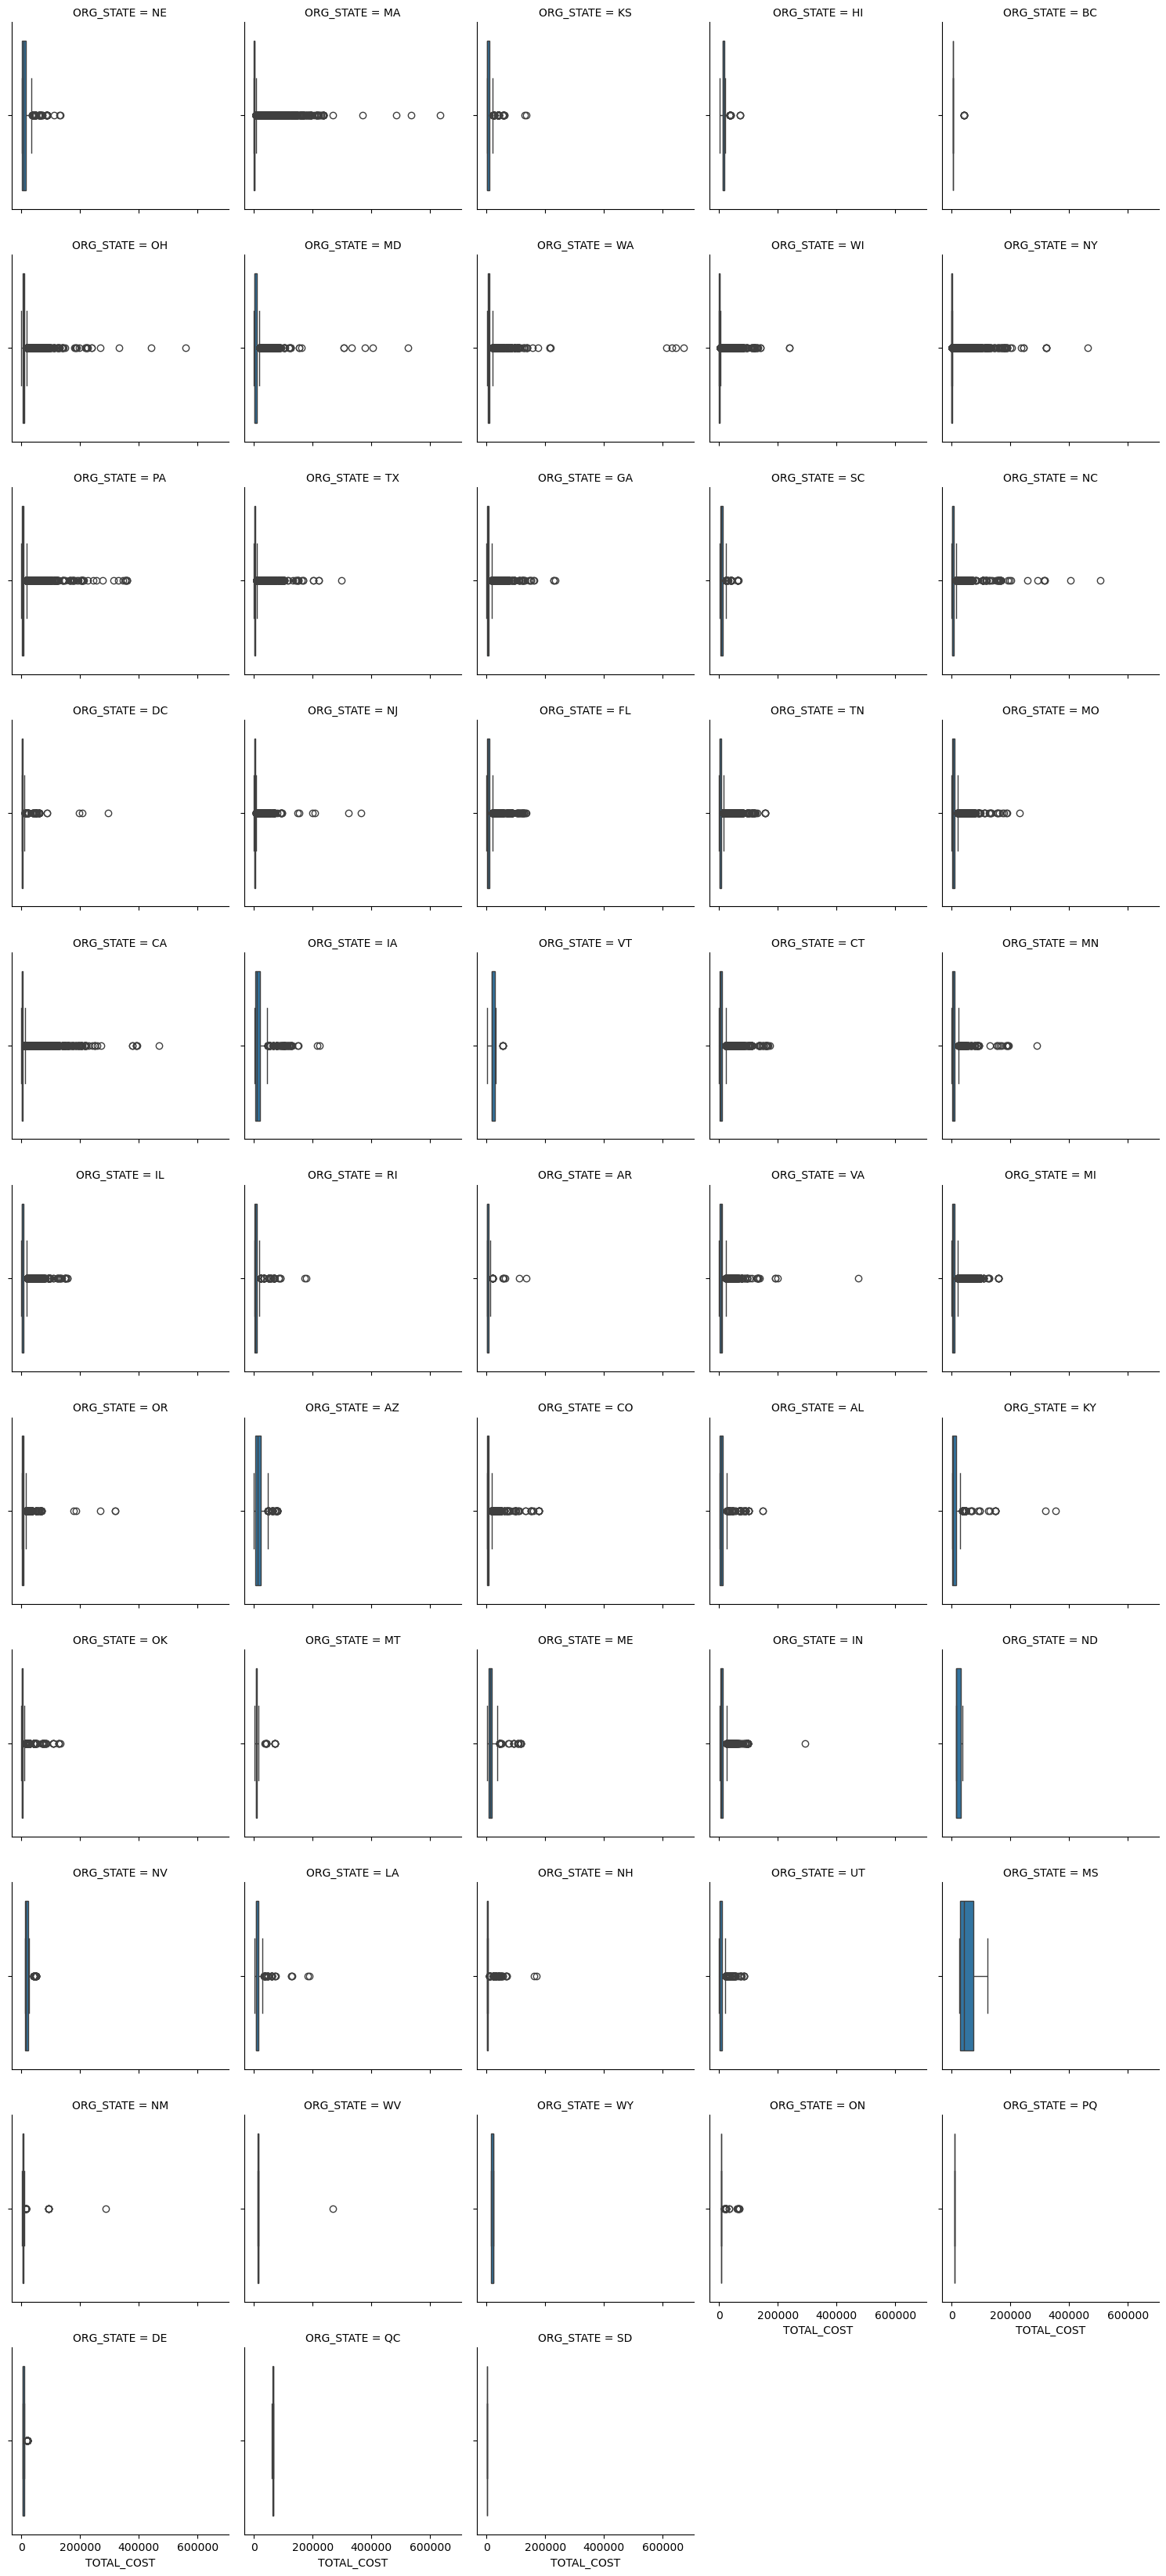

In [142]:
# Task 4: Run a statistical test to see if there is any bias in the NIH funding for different 
# model organisms (spoiler alert: answer is yes)

# Kruskal-Wallis: checks for stat. significant differences between them 
# assumptions: ordinal (yes), independent samples (yes), 
# distributions of the groups must have the same shape (uncertain)

rq5_stat_df = data[['ORG_STATE', 'TOTAL_COST']]

# create boxplot to check same shape 
boxplot = sns.FacetGrid(rq5_stat_df, col = 'ORG_STATE', col_wrap = 5, sharey = False)
boxplot.map(sns.boxplot, 'TOTAL_COST')

In [147]:
# boxplot is difficult to visualize so switching to checking if distribution has similar 
# variance via Levene (conclusion: statistically significant, assumption is violated)
list_of_taxons = rq5_stat_df['ORG_STATE'].unique()

data_by_state = []
kept_state = []
for state in list_of_taxons: 
    data_points = rq5_stat_df[rq5_stat_df['ORG_STATE'] == state]['TOTAL_COST'].values

    # avoids nan issue with fewer than 5 data points (gives us 50 groups)
    if len(data_points) > 5 and np.std(data_points) > 0: 
        data_by_state.append(data_points)
        kept_state.append(state)

f, p = levene(*data_by_state)
print(f, p)

71.15992613611205 0.0


In [148]:
# Run Kruskal-Wallis test (high significance value, indicating a bias)
H, p = kruskal(*data_by_state)
print(H, p)

59141.01526676471 0.0


Text(0.5, 1.0, 'Heat Map of Dunn Test Results (p-values)')

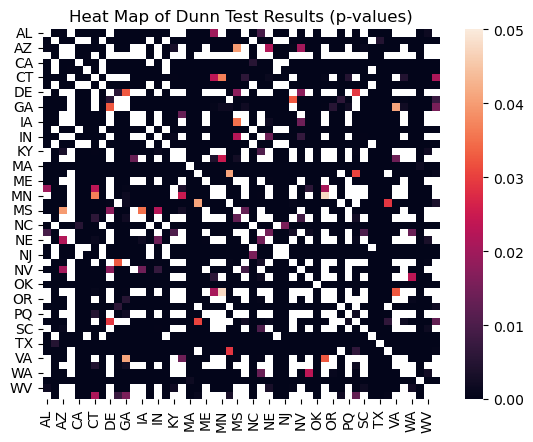

In [150]:
# Run Dunn Test (post-hoc)

# remove N/A values from df
dunn_df = rq5_stat_df[rq5_stat_df['ORG_STATE'].isin(kept_state)][['ORG_STATE', 'TOTAL_COST']]
p_values = sp.posthoc_dunn(
    dunn_df, 
    group_col = 'ORG_STATE',
    val_col = 'TOTAL_COST', 
    p_adjust='holm'
)


# use correlation matrix to visualize statistical significance (only looking at p<0.5)
plt.figure()
sns.heatmap(
    p_values.where(p_values <= 0.05),
    vmin = 0, 
    vmax = 0.05
)
plt.title("Heat Map of Dunn Test Results (p-values)")

# values are filtered for statistical significance, can see several extremely dark values
# specifically black, indicating high presence of bias in NIH funding based on taxon 

In [130]:
# -- PART 9: Has there been a change in amounts of funding awarded over time?

# year = 'FY' ('PROJECT_START', 'PROJECT_END')

